# Statistical Modelling - Assignment 1

# Muneel Haider 21i-0640

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

In [2]:
dataset_path = "iris_filtered.csv"
df = pd.read_csv(dataset_path)

print("Loaded Dataset:")
print(df.head())

Loaded Dataset:
   sepal_length  sepal_width  petal_length  petal_width  species
0           7.0          3.2           4.7          1.4        0
1           6.4          3.2           4.5          1.5        0
2           6.9          3.1           4.9          1.5        0
3           5.5          2.3           4.0          1.3        0
4           6.5          2.8           4.6          1.5        0


## Convert the above to a numpy array

In [3]:
labels = np.array(df.iloc[:, -1])
print("Extracted Labels:")
print(labels[:10])

labels_array = np.array(labels)
print(labels_array)

Extracted Labels:
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


## Pymc Model

In [4]:
with pm.Model() as bayesian_model:

    probability = pm.Beta("probability", alpha=1, beta=1)

    likelihood = pm.Bernoulli("likelihood", p=probability, observed=labels_array)

    posterior_samples = pm.sample(500, tune=500, chains=2, return_inferencedata=True, target_accept=0.95, cores=1)


Output()

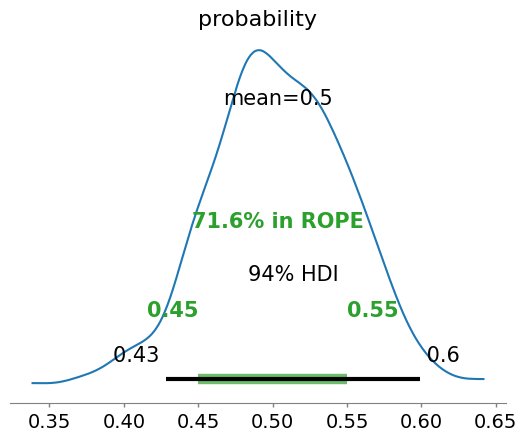

In [5]:
az.plot_posterior(posterior_samples, var_names=["probability"], rope=[0.45, 0.55])
plt.show()

## Summarizing posterior

In [6]:
posterior_summary = az.summary(posterior_samples)
print(posterior_summary)

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
probability  0.504  0.046   0.428    0.599      0.002    0.002     393.0   

             ess_tail  r_hat  
probability     412.0    1.0  


In [7]:
hdi_interval = az.hdi(posterior_samples.posterior["probability"], hdi_prob=0.94)
hdi_interval = hdi_interval["probability"].values

rope_range = [0.45, 0.55]

if hdi_interval[0] > rope_range[1] or hdi_interval[1] < rope_range[0]:
    result_decision = "The probability is significantly different from 0.5."

elif hdi_interval[0] >= rope_range[0] and hdi_interval[1] <= rope_range[1]:
    result_decision = "The probability is within ROPE and is practically equivalent to 0.5."

else:
    result_decision = "Uncertainty exists due to HDI overlapping with ROPE."

print("Decision Based on HDI and ROPE:", result_decision)
print("HDI Interval:", hdi_interval)

Decision Based on HDI and ROPE: Uncertainty exists due to HDI overlapping with ROPE.
HDI Interval: [0.42844041 0.59913924]


Output()

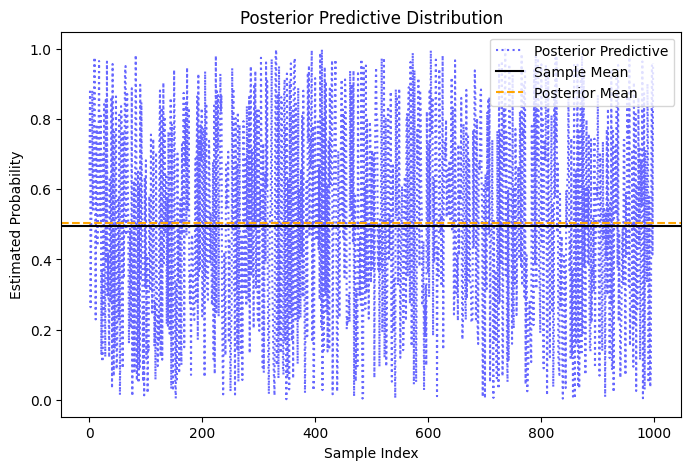

The model suggests that Setosa (0) is more likely.


In [8]:
with bayesian_model:

    generated_samples = pm.sample_posterior_predictive(posterior_samples, var_names=["probability"])
    generated_values = generated_samples.posterior_predictive["probability"].values.flatten()

mean_posterior = np.mean(posterior_samples.posterior["probability"].values)

plt.figure(figsize=(8, 5))
plt.plot(range(len(generated_values)), generated_values, linestyle="dotted", color="blue", alpha=0.6, label="Posterior Predictive")

plt.axhline(y=np.mean(generated_values), color="black", linestyle="-", label="Sample Mean")
plt.axhline(y=mean_posterior, color="orange", linestyle="dashed", label="Posterior Mean")

plt.xlabel("Sample Index")
plt.ylabel("Estimated Probability")

plt.legend()
plt.title("Posterior Predictive Distribution")
plt.show()

if np.mean(generated_values) > 0.5:
    print("The model suggests that Versicolor (1) is more likely.")

else:
    print("The model suggests that Setosa (0) is more likely.")

### your comment on this based on the ROPE and HDI comparison, ( See Book chapter 2 for more)

This method is good implementation of Bayesian inference since we use a range of values instead of one number. The if else statements decide whether the bias is 0.5, close or near it, or unclear. This makes sure that we dont reply on just one estimate but on a whole range of them.


-----

-----


### Generate the next 100 samples based on the learned parameter of the PyMC model ***(Prediction step***)

Output()

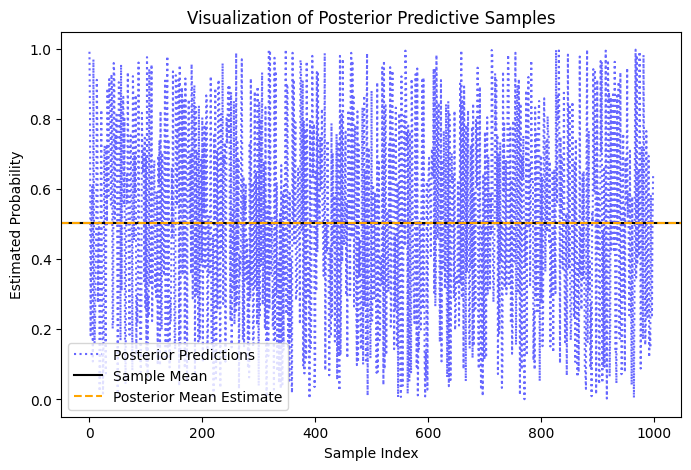

In [9]:
with bayesian_model:
    predictive_posterior = pm.sample_posterior_predictive(posterior_samples, var_names=["probability"])
    predictive_samples = predictive_posterior.posterior_predictive["probability"].values.flatten()

# Compute the mean of posterior estimates
estimated_mean = np.mean(posterior_samples.posterior["probability"].values)

# Visualization of posterior predictive distribution
plt.figure(figsize=(8, 5))

plt.plot(range(len(predictive_samples)), predictive_samples, linestyle="dotted", color="blue", alpha=0.6, label="Posterior Predictions")

plt.axhline(y=np.mean(predictive_samples), color="black", linestyle="-", label="Sample Mean")

plt.axhline(y=estimated_mean, color="orange", linestyle="dashed", label="Posterior Mean Estimate")

plt.xlabel("Sample Index")
plt.ylabel("Estimated Probability")
plt.legend()
plt.title("Visualization of Posterior Predictive Samples")
plt.show()

### your one line openion on the above prediction based on the learned parameter of the model ?

Based on posterior probability (either 0 or 1), the model predicts the class with highest learned bias param.

---